In this tutorial, we will integrate what we’ve learned by building a basic image classification model. Our task will be to classify handwritten digits using the famous MNIST dataset.

 * Note: We will also explore how to utilize a GPU to accelerate training.

 *Reference video: https://www.youtube.com/watch?v=oPhxf2fXHkQ&list=PLqnslRFeH2UrcDBWF5mfPGpqQDSta6VK4&index=14*

In [ ]:
import torch
import torch.nn as nn
import torchvision # for the MNIST dataset, images of hand-written digits
import torchvision.transforms as transforms # for organizing the MNIST dataset
import matplotlib.pyplot as plt

# device config, use GPU if there is one, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# hyper parameters
input_size = 784 # 28x28 -> the image dataset we will use containing images with 28*28 pixels
hidden_size = 100
num_classes = 10 # the output size, there are 10 possible output from 0 - 9
num_epochs = 2
batch_size = 100
learning_rate = 0.001
"""
- Epoch:        An epoch refers to one complete pass through the entire training dataset.
                In each epoch, the model sees all the training examples once.

- Batch:        Instead of passing the entire dataset to the model at once, we divide it into smaller subsets called batches.

- Iteration:    An iteration refers to a single update of the model’s parameters.
                In one iteration, the model processes one batch of data.

--> If we have 1000 images and a batch size of 100, we’ll have 10 batches in each epoch, hence 10 iterations in each epoch

Reference of the relations between epochs, batches, and iterations: https://www.youtube.com/watch?v=K20lVDVjPn4
"""

#### Loading MNIST (from PyTorch library)
train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                           transform=transforms.ToTensor(), download=True) # download=True for the first time to download this dataset

test_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                          transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, shuffle=False)
"""
PyTorch provides built-in `DataLoader` and `transforms` to efficiently organize and process large datasets in common formats.
While these tools are not strictly necessary, they are no doubt convenient when working with pre-existing datasets, as they
handle batching, shuffling, and data transformations easily.

However, we won’t focus on these packages in this tutorial, as they are more relevant for tasks involving pre-existing datasets,
such as image classification. For tasks like Reinforcement Learning or functional optimization problems, which we are focusing on,
most data are generated dynamically during training. In such cases, the `DataLoader` and `transforms` functionalities are less
useful since we work with training data that is created on the fly.

To learn the basics of PyTorch `DataLoader` and `transforms`, the following references are recommended:
https://www.youtube.com/watch?v=PXOzkkB5eH0&list=PLqnslRFeH2UrcDBWF5mfPGpqQDSta6VK4&index=9
https://www.youtube.com/watch?v=X_QOZEko5uE&list=PLqnslRFeH2UrcDBWF5mfPGpqQDSta6VK4&index=10

It's also worth noting that if you're working on both PyTorch and TensorFlow projects simultaneously, you might prefer to organize
datasets using interchangeable Python code (such as `NumPy` or `Pandas`). This allows for greater flexibility across both frameworks,
as it avoids locking data loading into PyTorch's `DataLoader` or TensorFlow's `tf.data` pipeline. By keeping dataset handling
framework-agnostic, you can easily adapt your code for use in both environments.
"""
#### Loading MNIST ends

examples = iter(train_loader)
samples, labels = next(examples)  # In Python 3.x, use the built-in next() function instead of examples.next()
print(samples.shape, labels.shape)
"""
return torch.Size([100, 1, 28, 28]) torch.Size([100])

torch.Size([100, 1, 28, 28]) -> 100 for the asked batch size, 1 for black and white channel (no color channel)
the last two 28x28 are the pixel array.

the torch.Size([100]) are the labels of data. Each data in the batch has a label (number 0 - 9),
so here we have 100 return labels corresponding to the 100 data in the batch

torch.Size([100, 1, 28, 28]):
- The first dimension (100) represents the batch size, which we set to 100. (loaded with dataloader)
- The second dimension (1) represents the number of channels. Since these are black-and-white images, we only have 1 channel (no color channels like RGB).
- The last two dimensions (28x28) represent the height and width of the image in pixels, corresponding to the 28x28 pixel array.

torch.Size([100]):
- This represents the labels of the data. Since each data sample in the batch has one label (a digit from 0 to 9), we have 100 labels corresponding to the 100 images in the batch.
"""


torch.Size([100, 1, 28, 28]) torch.Size([100])


'\nreturn torch.Size([100, 1, 28, 28]) torch.Size([100]) \n\ntorch.Size([100, 1, 28, 28]) -> 100 for the asked batch size, 1 for black and white channel (no color channel)\nthe last two 28x28 are the pixel array. \n\nthe torch.Size([100]) are the label of data. Each data in the batch has a label (number 0 - 9),\nso here we have 100 return label corresponding to the 100 data in the batch\n'

<function matplotlib.pyplot.show(close=None, block=None)>

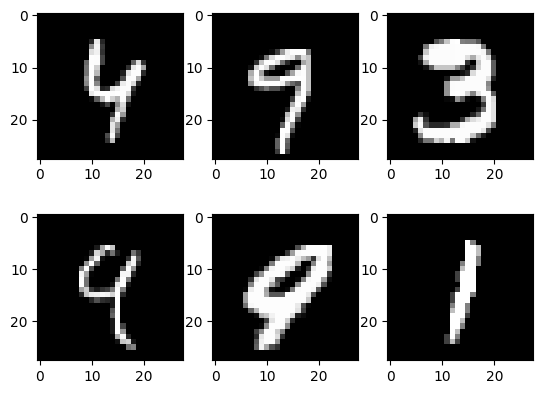

In [ ]:
# Let's take a look at the first 6 images in our samples
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(samples[i][0], cmap='gray')
    # The [0] is to access the color channel (black and white) for the (28, 28) image
plt.show()

In [ ]:
# Define our Neural Network
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.activationF = nn.ReLU() # different from tutorial5, here we try to apply the activation function as a module
        self.l2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.l1(x)
        x = self.activationF(x)
        output = self.l2(x)
        return output

# Instantiate our Neural Network
model = NeuralNet(input_size, hidden_size, num_classes)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
"""
The loss function, also known as the criterion, again, is a measure of how well the model's predictions match the target labels.
In the previous tutorial, we defined the loss function (Mean Squared Error) manually.
However, PyTorch provides built-in loss functions, such as:
- `nn.MSELoss()` for regression problems.
- `nn.CrossEntropyLoss()` for classification problems, which we are using here.

**CrossEntropyLoss** is commonly used for classification tasks where the model outputs probabilities over multiple classes.
It compares the predicted class probabilities with the true class labels and penalizes incorrect predictions.

In our case, since we are classifying digits (0-9), CrossEntropyLoss is well-suited because it handles multi-class classification efficiently.

To learn more about loss functions (e.g. Softmax and Cross-Entropy) used in classification problems, please check:
https://www.youtube.com/watch?v=7q7E91pHoW4&list=PLqnslRFeH2UrcDBWF5mfPGpqQDSta6VK4&index=11

To explore different built-in PyTorch loss functions, visit the documentation:
https://pytorch.org/docs/stable/nn.html#loss-functions
"""
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # Adam optimizer
# Adam: https://pytorch.org/docs/stable/generated/torch.optim.Adam.html


# Main training loop
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Flatten the 28x28 images into a vector of 784 pixels
        # [100, 1, 28, 28] -> [100, 784]
        # Send the flattened images and labels to the chosen device (GPU if available)
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device) # remember to send the labels to device too! (they are part of the backward pass)
        # The "-1" in reshape automatically calculates the batch size (here should be 100) based on the input dimension

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print training info every 100 steps
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

# testing and evaluation our result
with torch.no_grad(): # not for training, no need of computational graph
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)

        # Get the predicted class (index of the highest value in the output tensor)
        _, predictions = torch.max(outputs, 1)
        # torch.max() returns (max value, index of max value). We use the index to get the predicted class.


        n_samples += labels.shape[0] # return the number of samples in the current batch (100)
        n_correct += (predictions == labels).sum().item()
        # if predictions == labels, it will return True, which is also a value "1".

    # Calculate accuracy as a percentage
    acc = 100.0 * n_correct / n_samples
    print(f'accuracy = {acc}')


epoch 1 / 2, step 100/600, loss 0.4461
epoch 1 / 2, step 200/600, loss 0.3122
epoch 1 / 2, step 300/600, loss 0.4404
epoch 1 / 2, step 400/600, loss 0.2136
epoch 1 / 2, step 500/600, loss 0.3662
epoch 1 / 2, step 600/600, loss 0.1354
epoch 2 / 2, step 100/600, loss 0.1791
epoch 2 / 2, step 200/600, loss 0.2808
epoch 2 / 2, step 300/600, loss 0.1647
epoch 2 / 2, step 400/600, loss 0.1218
epoch 2 / 2, step 500/600, loss 0.2144
epoch 2 / 2, step 600/600, loss 0.1981
accuracy = 95.52


#About flattening the data:

In PyTorch, both `reshape()` and `view()` are used to change the shape of a tensor, but they differ in how they operate and the conditions in which they can be used:

1. `view()`

	•	Operation: `view()` returns a new tensor with the same data but a different shape. However, it requires that the tensor be contiguous in memory. If the tensor is not contiguous, you may encounter an error.
    
	•	Contiguous Memory: PyTorch stores tensors in memory as contiguous blocks, but certain operations (like slicing or transposing) can cause the data to be stored in a non-contiguous manner. `view()` can only be used on tensors that are contiguous in memory. You can use `.contiguous()` to ensure a tensor is contiguous before using `view()`.

When to Use `view()`:

	•	When you want to change the shape of a tensor, and you are sure or can make the tensor contiguous.
	•	Useful for reshaping without creating a new copy of the tensor if the underlying data layout allows it.

2. `reshape()`

	•	Operation: `reshape()` also returns a tensor with a different shape, but it does not require the tensor to be contiguous. If the tensor is not contiguous, `reshape()` will internally make a copy of the data if needed. This provides more flexibility but might be slightly less efficient since it can involve copying data.

	•	Memory Safety: `reshape()` is generally more flexible since it will handle both contiguous and non-contiguous tensors.

When to Use `reshape()`:

	•	When you need to reshape a tensor and don’t want to worry about whether the tensor is contiguous or not.
	•	When you prefer flexibility and don’t mind the potential overhead of creating a new tensor.

In this tutorial, we successfully built a simple neural network to classify images from the MNIST dataset. While this fully connected network performs well on simple tasks like digit classification, more complex image processing tasks often require more sophisticated architectures.

For most advanced computer vision tasks, such as object detection, image segmentation, or more challenging classification tasks, **Convolutional Neural Networks (CNNs)** are essential for improving performance. CNNs are specifically designed to capture spatial hierarchies in images, which makes them much more effective for image-related tasks.

If you're interested in learning more about CNNs and their application in deep learning, I recommend checking out this YouTube video: https://www.youtube.com/watch?v=pDdP0TFzsoQ&list=PLqnslRFeH2UrcDBWF5mfPGpqQDSta6VK4&index=14
